In [15]:
import libs as lb
import pickle as pk
import pandas as pd
import numpy as np
from numpy import *
import time
import julian
import matplotlib.pyplot as plt
from tqdm import *
from pylab import *
from multiprocessing import Pool
import pickle
import scipy.stats
from scipy.linalg import qr, solve, lstsq
from sklearn.cluster import KMeans
from mpl_toolkits.basemap import Basemap
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def lon_lat_juld_test(index_,GulfStreamIndex,coords_g):
    """

    """
    
    lon = coords_g['lon']
    lat = coords_g['lat']
    juld = coords_g['juld']
    
    lon_test = np.zeros((index_.shape[0],1))
    lat_test = np.zeros((index_.shape[0],1))
    juld_test = np.zeros((index_.shape[0],1))

    for k in range(index_.shape[0]):
        lon_test[k,0] =  lon[np.where(GulfStreamIndex == index_[k])][0]
        lat_test[k,0] =  lat[np.where(GulfStreamIndex == index_[k])][0]
        juld_test[k,0] =  juld[np.where(GulfStreamIndex == index_[k])][0]
        
        if k % 1000 == 0:
            print((k/index_.shape[0])*100, '%')
    
    np.savetxt('lon_test.txt', lon_test)
    np.savetxt('lat_test.txt', lat_test)
    np.savetxt('juld_test.txt', juld_test)
    
    return lon_test, lat_test, juld_test

In [26]:
def prior_prob_space_plot(lon_test,lat_test,map,pi_hat):
    """
    
    """
    lons = lon_test
    lats = lat_test

    x, y = map(lons, lats)
    markers = np.full((lon_test.shape[0], 1), 1)
    figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
    for i in range(pi_hat.shape[1]):
        plt.subplot(3,3,i+1)
        ax = plt.gca()
        map.scatter(x, y, c = pi_hat[:,i].reshape(pi_hat.shape[0]), s = markers)
        plt.title('Dynamic mode: '+str(i+1))
        map.drawcoastlines()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(cax=cax)

In [28]:
def prior_prob_time_plot(pi_hat,juld_test, K, m):
    """
    - K: number of classes
    - m: size of the windows
    """
    encoded_juld = [julian.from_jd(round(x), fmt='mjd') for x in juld_test]
    days_in_year =  np.asarray([x.day + (x.month -1)*30 for x in encoded_juld])
    
    # prior probality per days
    prior_prob_days = np.zeros((K,365))
    
    days = np.linspace(1,365,365).astype(int)
    
    plt.figure(figsize=(20,10))
    for day in days:
        day_mask = np.where(days_in_year == day)
        if size(day_mask) != 0:
            prior_prob_days[:,day-1] = mean(pi_hat[day_mask], axis = 0)
    
    mask = 1/m*np.ones(m)
    
    segment = int(365/len(mask))
    
    prior_prob_days_mean = np.zeros((K,segment))
    
    for k in range(segment):
        if (k == 0) or (k == segment-1):
            w = prior_prob_days[:,k*len(mask):(k+1)*len(mask)]
            prior_prob_days_mean[:, k] = w@mask
        else:
            w = prior_prob_days[:,k*len(mask)-3:(k+1)*len(mask)-3]
            prior_prob_days_mean[:, k] = w@mask
    
    days_mean = np.asarray([i for i in range(segment)])*m
    
    for k in range(K):
        plt.scatter(days_mean[:-2],prior_prob_days_mean[k,:-2])
        plt.plot(days_mean[:-2],prior_prob_days_mean[k,:-2], label = 'Mode-'+str(k+1))
        plt.legend()
        plt.ylabel('priori probability')
        plt.xlabel('days')
        plt.title('Priori probability variation in time')

## I. Result visualization on the GulfStream region


### Load Coordinates

In [5]:
# Load the data
load = True
if load:    
    coords_g = pd.read_pickle('GulfStream_Coords.pkl')
else:
    coords_g = lb.lon_lat_juld('GulfStream')

In [6]:
# load the coordinates of the test
load = True
if load:
    lon_test, lat_test, juld_test = np.loadtxt('lon_test.txt'), np.loadtxt('lat_test.txt'),np.loadtxt('juld_test.txt')
else:
    lon_test, lat_test, juld_test = lon_lat_juld_test(index_test1_,GulfStreamIndex,coords_g)

In [7]:
index_test1_ = np.loadtxt('test_index.txt').astype(int)
GulfStreamIndex = np.linspace(0,coords_g['lon'].shape[0]-1,coords_g['lon'].shape[0]).astype(int)

### Visulize the global maps

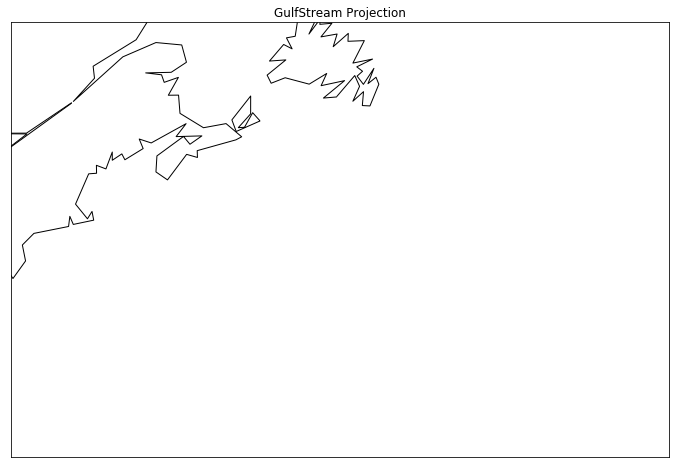

In [13]:
fig = plt.figure(num=None, figsize=(12, 8) )
map = Basemap(projection='merc',llcrnrlat=30,urcrnrlat=50,llcrnrlon=-75,urcrnrlon=-35,resolution='c')
map.drawcoastlines()
plt.title("GulfStream Projection")
plt.show()

### Test 1 -  4 classes

#### Plot the prorior probabilities on the maps

In [20]:
pi_hat_test1_ = np.loadtxt('pi_hat_1_'+str(4)+'.txt')

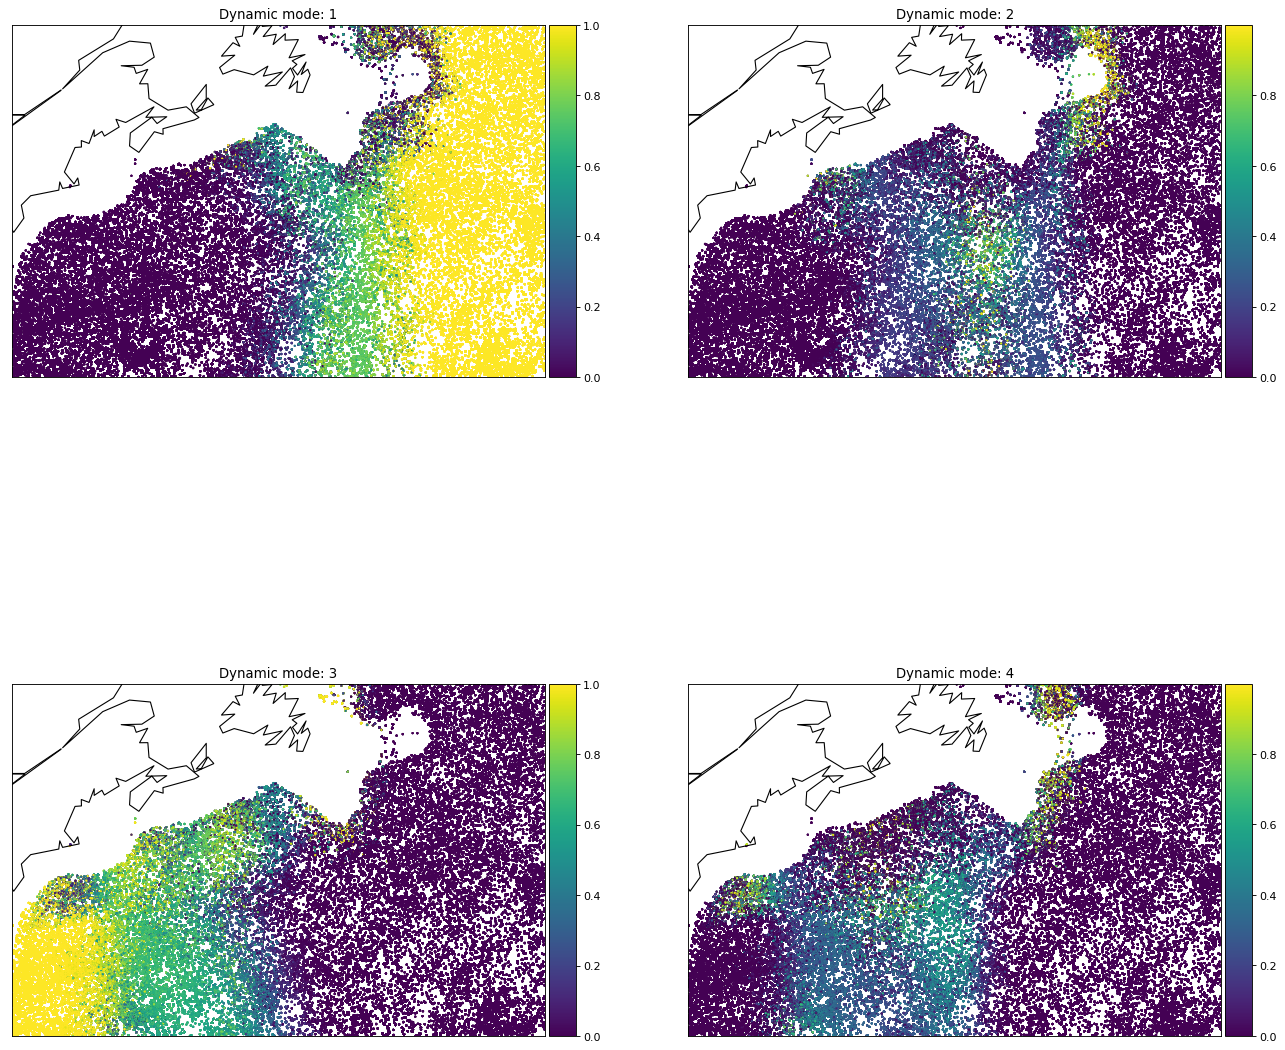

In [24]:
prior_prob_space_plot(lon_test,lat_test,map,pi_hat_test1_)

Figure out that ther're two visible clusters

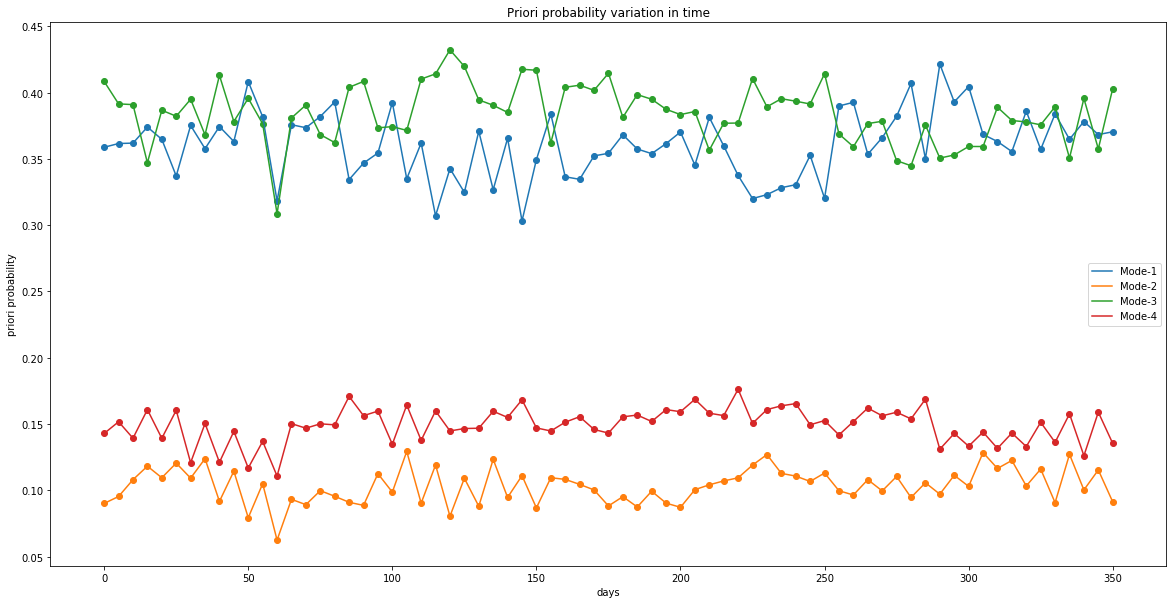

In [29]:
prior_prob_time_plot(pi_hat_test1_,juld_test, 4,5)

### Test 1 -  8 classes

In [25]:
pi_hat_test1_8 = np.loadtxt('pi_hat_1_'+str(8)+'.txt')

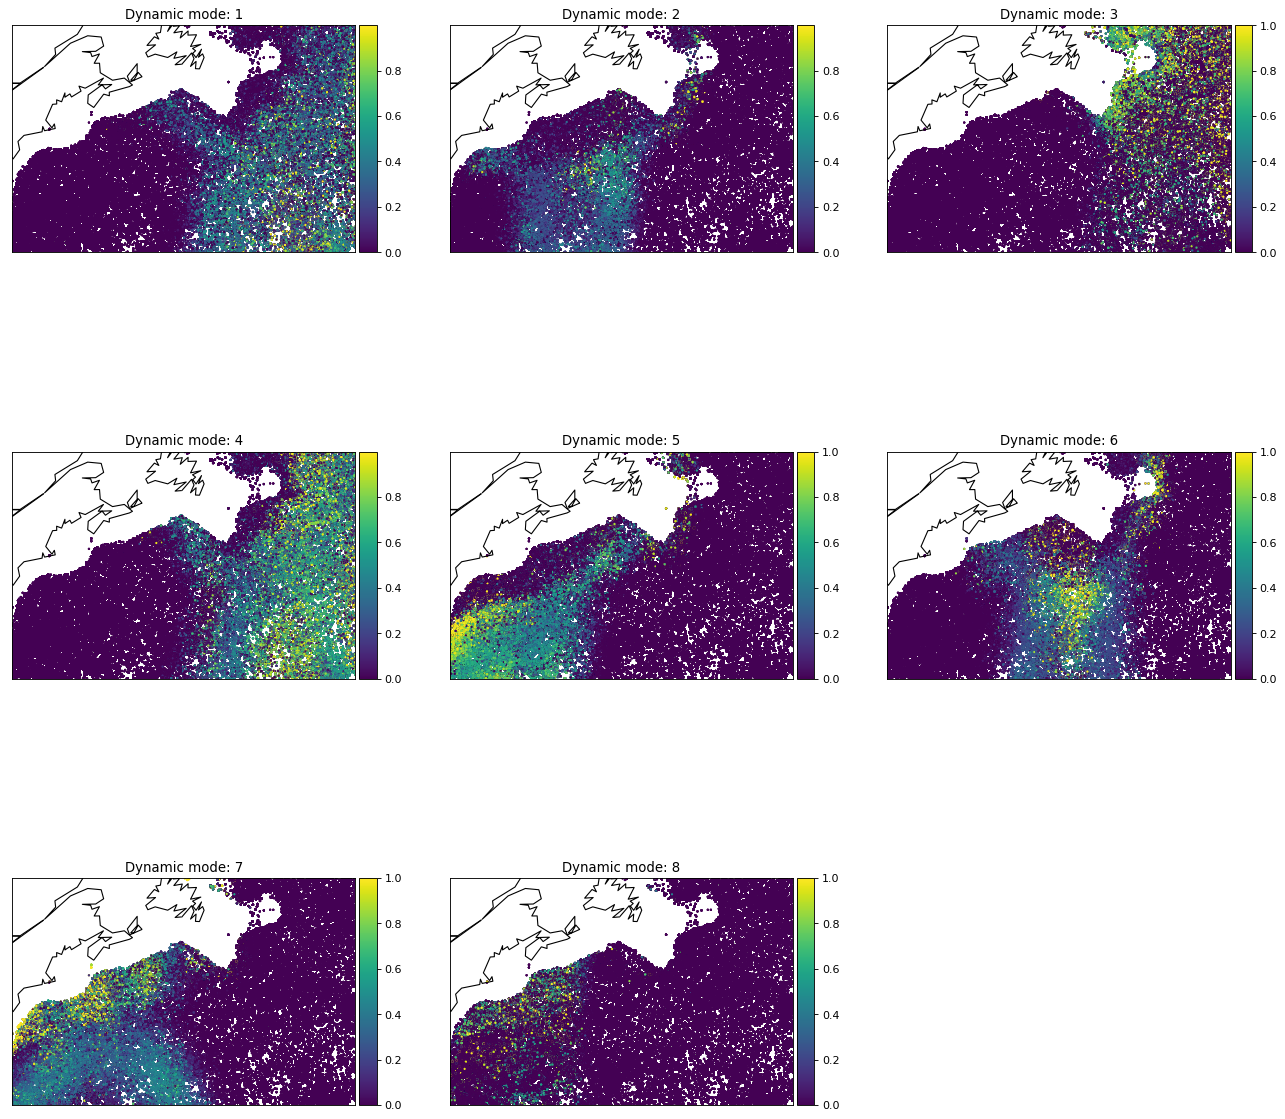

In [27]:
prior_prob_space_plot(lon_test,lat_test,map,pi_hat_test1_8)

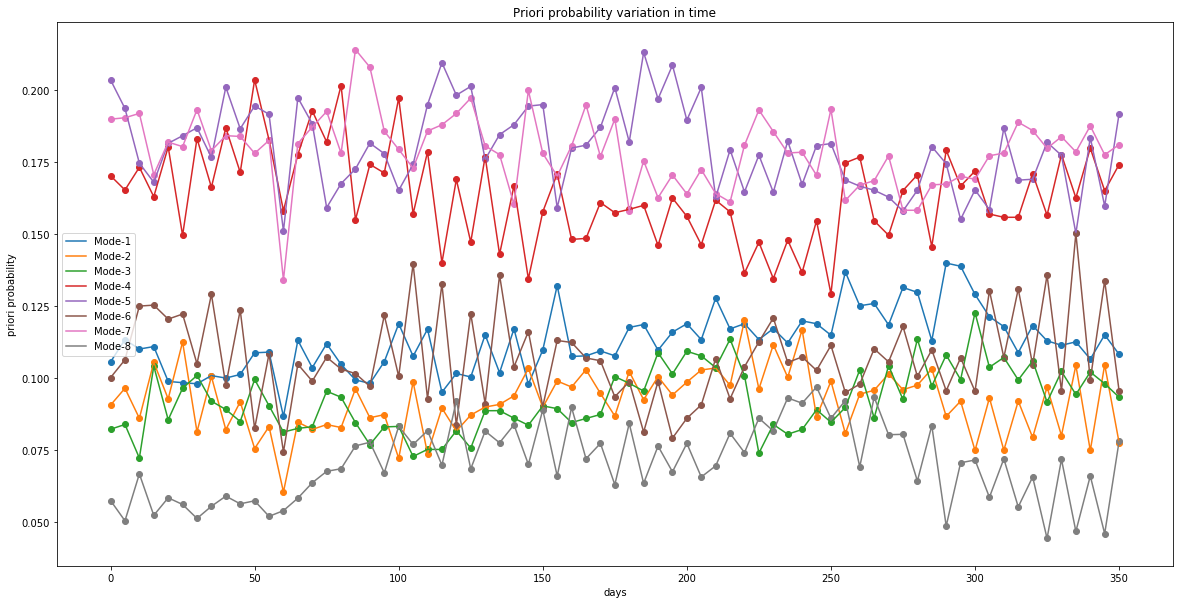

In [31]:
prior_prob_time_plot(pi_hat_test1_8,juld_test, 8,5)

### Test 2 - 3 classes

In [10]:
pi_hat_test2_3 = np.loadtxt('pi_hat_2_'+str(3)+'.txt')

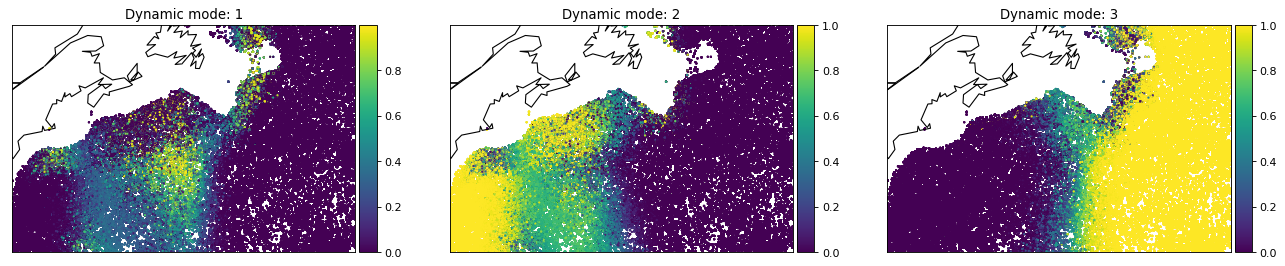

In [19]:
prior_prob_space_plot(lon_test,lat_test,map,pi_hat_test2_3)

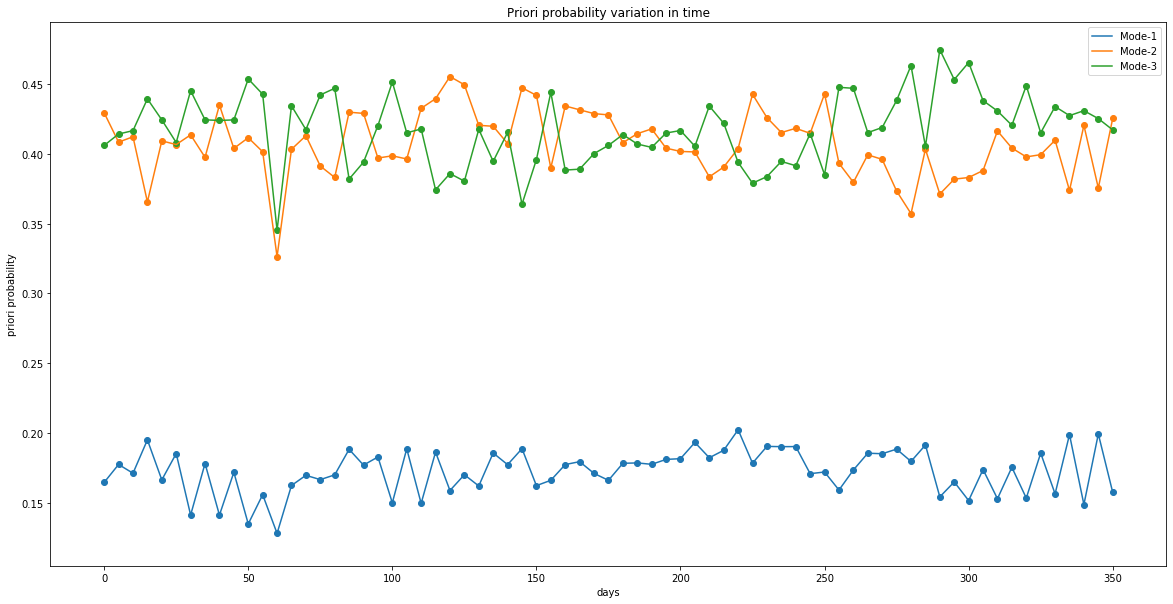

In [32]:
prior_prob_time_plot(pi_hat_test2_3,juld_test, 3,5)